In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib
#%matplotlib notebook
#%matplotlib qt5
%matplotlib inline
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0) # bigger figures

import seaborn as sns
sns.set() # better looking figs

# hide warnings for clarity
import warnings
warnings.filterwarnings('ignore')

# our own set of small helper functions for plotting, etc
from utils import plot_embedding, plot_compare_embeddings, show_heatmap, plot_confusion_matrix

Load dataset, rename and re-order columns where necessary.

In [2]:
data = pd.read_csv("../Data/Input/fulldata.csv")
data["clipId"] = data["clipName"].apply(lambda x: x[-8:-6])

# re-order columns + keep only useful ones
data = data[['pptID','fileName', 'condition', 'age', 'gender', 'nationality', 'firstLang', 'trial', 'clipId', 'freetext',
 'q01', 'q02', 'q03', 'q04', 'q05', 'q06', 'q07', 'q08', 'q09', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17',
 'q18', 'q19', 'q20', 'q21', 'q22', 'q23', 'q24', 'q25', 'q26', 'q27', 'q28', 'q29', 'q30']]

Rename `qXX` columns with the names of the actual constructs tested in the questionnaire.

Notes:
- `condition=1` is the 'Movement-only' condition, `condition=2` is the 'Full-scene' condition
- each participant `pptID` watched 4 different clips, hence 4 rows per participant

In [3]:
constructs=["Sad", "Happy", "Angry", "Excited", "Calm", 
            "Friendly", "Aggressive", "Engaged", "Distracted", 
            "Bored", "Frustrated","Dominant","Submissive"]

index = data.columns.tolist()
index = index[0:10] + ["Competing", "Cooperating", "PlaySeparate", "PlayTogether"] + [c for c1 in constructs for c in ['left' + c1, 'right' + c1]]
data.columns=index
#data

## Pre-processing

For each left/right pair of constructs, compute the absolute difference and the sum (shifted to [-2, +2] interval).

This provides insight on the imbalance of the given construct between the children (difference), and the overall 'strength' of the construct in the clip (sum).

In [4]:
for c in constructs:
    data["diff"+c] = abs(data["left" + c] - data["right" + c]) #calculating difference
    data["sum"+c] = data["left" + c] + data["right" + c] - 4 #calculating sum

Create 2 lists of columns names, one for diff/sum constructs, one for left/right constructs.

In [5]:
columnsLeftRight=[]
columnsDiffSum=[]

for c in constructs:
    columnsLeftRight.append("left" + c)
    columnsLeftRight.append("right" + c)
    
    columnsDiffSum.append("diff" + c)
    columnsDiffSum.append("sum" + c)


# by default, work with differences & sum for each constructs
selectedColumns=columnsDiffSum

# work with differences & sum and the four questions about group dynamics
allQuestionsDiffSum = ["Competing", "Cooperating", "PlaySeparate", "PlayTogether"] + columnsDiffSum

# work with left/right ratings and the four questions about group dynamics i.e. raw ratings
allQuestionsLeftRight = ["Competing", "Cooperating", "PlaySeparate", "PlayTogether"] + columnsLeftRight

**Define several useful 'partial' views of the data.** <br>
Dataframes for each condition. <br>
Responses to left/right questions as dataframe and as array. <br>
Clip names. <br>
Mean ratings per clip.

In [6]:
#FULL-SCENE DATA

fullscene_df = data[data["condition"]==2] # dataframe showing full scene data only

# the responses to the 26 left/right Likert-scale questions
fullscene_ratings_df = fullscene_df[selectedColumns].astype(float)
fullscene = fullscene_ratings_df.values # the underlying numpy array, needed for clustering

# clip names
fullscene_labels = fullscene_df["clipId"].values

# mean ratings per clip
fullscene_means = fullscene_df.groupby(["clipId"]).mean()[selectedColumns]

In [7]:
#MOVEMENT-ALONE DATA

move_df=data[data["condition"]==1] # dataframe showing movement alone data only

# the responses to the 26 left/right Likert-scale questions
move_ratings_df=move_df[selectedColumns].astype(float)
move=move_ratings_df.values # the underlying numpy array, needed for clustering

# clip names
move_labels=move_df["clipId"].values

# mean ratings per clip
move_means=move_df.groupby(["clipId"]).mean()[selectedColumns]

# Inter-Rater Agreement

Calculate Kirppendorff's alpha to look at how much participants in each condition agreed on their ratings for each clip (lighter color means higher agreement).

In [8]:
import krippendorff

krip={}

# agreement for fullscene condition for all questions
for clipName, group in fullscene_df[["clipId"] + allQuestionsLeftRight].groupby(["clipId"]): # working with all raw ratings
    krip[clipName]=(krippendorff.alpha(group.values[:,1:].astype(int),level_of_measurement='interval'), group.shape[0])

# agreement for movement-alone condition for all questions
for clipName, group in move_df[["clipId"] + allQuestionsLeftRight].groupby("clipId"):
    krip[clipName]=krip[clipName] + (krippendorff.alpha(group.values[:,1:].astype(int),level_of_measurement='interval'), group.shape[0])

# create random ratings and calculate "baseline" agreement score
for clipName, group in move_df[["clipId"] + allQuestionsLeftRight].groupby("clipId"):
    ratings = group.values[:,1:].astype(int)
    ratings = np.random.randint(0,5,ratings.shape)
    krip[clipName]=krip[clipName] + (krippendorff.alpha(ratings,level_of_measurement='interval'), group.shape[0])

    
krippendorff_df=pd.DataFrame.from_dict(krip,orient="index", columns=["Fullscene alpha", "N", "Movement-Alone alpha", "N","Random ratings alpha", "N"])

show_heatmap(krippendorff_df[["Fullscene alpha", "Movement-Alone alpha", "Random ratings alpha"]].round(3), cmap="summer")

,Fullscene alpha,Movement-Alone alpha,Random ratings alpha
01,0.446,0.186,-0.011
02,0.181,0.27,0.02
03,0.393,0.369,-0.014
04,0.444,0.262,-0.006
05,0.328,0.283,-0.015
06,0.463,0.359,-0.017
07,0.091,0.236,-0.003
08,0.339,0.312,-0.03
09,0.097,0.058,-0.013
10,0.396,0.086,-0.023


Question: did participants in the fullscene condition agree more in their ratings of each clip than participants in the movement-alone condition?

We test this by comparing the agreement scores in the fullscene vs movement-alone videos, using an paired samples T-test. 

In [9]:
from scipy.stats import ttest_rel
from math import sqrt

fullscene_krip = krippendorff_df["Fullscene alpha"]
move_krip = krippendorff_df["Movement-Alone alpha"]

print('Mean Kripp Alpha Fullscene:', fullscene_krip.mean())
print('SD:', fullscene_krip.std())
print('Mean Kripp Alpha Movement:', move_krip.mean())
print('SD:', move_krip.std())

print('Paired Samples T-Test:', ttest_rel(fullscene_krip, move_krip))

cohens_d = (fullscene_krip.mean() - move_krip.mean()) / (sqrt((fullscene_krip.std() ** 2 + move_krip.std() ** 2) / 2))

print("Cohen's d:", cohens_d)

Mean Kripp Alpha Fullscene: 0.32795503407453647
SD: 0.11308789017332392
Mean Kripp Alpha Movement: 0.25168714306863765
SD: 0.0807126694196466
Paired Samples T-Test: Ttest_relResult(statistic=2.955422785203005, pvalue=0.008124095387554918)
Cohen's d: 0.7763181922755471


T-test comparing krippendorf's alpha in the movement alone condition against 0 to see if there is agreement.

In [10]:
from scipy.stats import ttest_1samp
print('One Sample T-Test:', ttest_1samp(move_krip, 0))

cohens_d = (move_krip.mean()-0) / move_krip.std()

print("Cohen's d:", cohens_d)

One Sample T-Test: Ttest_1sampResult(statistic=13.94550731653036, pvalue=1.9697611627751207e-11)
Cohen's d: 3.1183102340482556


# Automatic Labelling of Internal States

Multi-label classification using k-Nearest Neighbours (k=3). 

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer



training_ground_truth = { '01': ['Aggressive'],
                         '02': ['Excited', 'Aggressive', 'Aimless'],
                         '03': ['Excited', 'Fun'],
                         '04': ['Cooperative'],
                         '05': ['Bored', 'Aimless'],
                         '06': ['Cooperative'],
                         '07': ['Dominant'],
                         '08': ['Bored', 'Fun'],
                         '09': ['Cooperative'],
                         '10': ['Cooperative', 'Dominant'],
                         '11': ['Cooperative', 'Dominant'],
                         '12': ['Aggressive', 'Aimless'],
                         '13': ['Excited', 'Aggressive', 'Aimless'],
                         '14': ['Aggressive'],
                         '15': ['Dominant'],
                         '16': ['Cooperative', 'Dominant'],
                         '17': ['Excited', 'Aggressive'],
                         '18': ['Aggressive', 'Dominant'],
                         '19': ['Dominant'],
                         '20': ['Excited']}

mlb = MultiLabelBinarizer()
mlb.fit(training_ground_truth.values())

def create_datasets(training=data, testing=None, cols=allQuestionsDiffSum, test_size=0.2, use_clip_id_as_label=False, random_labels=False, random_state=None):
    """Returns a training dataset and training labels, and a testing dataset and testing labels.
    
    If testing is None, it randomly splits the training dataframe (at test_size).
    """


    if testing is None:
        
        if use_clip_id_as_label:
            labels = list(training["clipId"].map(int))
        else:
            labels = []
            for id in training["clipId"]:
                labels.append(training_ground_truth[id])

        data = training[cols].values

        training_data, testing_data, training_labels, testing_labels = train_test_split(data, labels, test_size=test_size, random_state=random_state)

        if not use_clip_id_as_label:
            
            training_labels, testing_labels = mlb.transform(training_labels), mlb.transform(testing_labels)
            
            if random_labels:
                for labels in training_labels:
                    np.random.shuffle(labels)                 
                np.random.shuffle(training_labels)             
            

        return training_data, testing_data, training_labels, testing_labels
    
    else:
        
        if use_clip_id_as_label:
            training_labels = list(training["clipId"].map(int))
            testing_labels = list(testing["clipId"].map(int))
        else:
            labels = []
            for id in training["clipId"]:
                labels.append(training_ground_truth[id])

            training_labels = mlb.transform(labels)

            labels = []
            for id in testing["clipId"]:
                labels.append(training_ground_truth[id])

            testing_labels = mlb.transform(labels)

            if random_labels:
                if random_labels:
                    for labels in training_labels:
                        np.random.shuffle(labels)                 
                    np.random.shuffle(training_labels) 

        
        training_data = training[cols].values
        testing_data = testing[cols].values

        return training_data, testing_data, training_labels, testing_labels

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

def train(training_data, training_labels):
    
    #clf = RandomForestClassifier()
    clf = KNeighborsClassifier(n_neighbors=3)
    #clf = ExtraTreeClassifier(random_state=0)


    clf.fit(training_data, training_labels)
    
    return clf

def predict(clf, testing_data, inverse_transform_labels=True):
    p = clf.predict(testing_data)
    if inverse_transform_labels:
        return mlb.inverse_transform(p) 
    else:
        return p

In [13]:
import sklearn
import sklearn.metrics as metrics
    
def run_classification(training, 
                       testing=None, 
                       cols=allQuestionsDiffSum, 
                       use_clip_id_as_label=False, 
                       random_labels=False,
                       crossvalidation_iterations=50):
    """
    Metrics for multi-label classification coming form Sorower, Mohammad S. "A literature survey on algorithms for multi-label learning." Oregon State University, Corvallis (2010).
    """
    
    results = {"Accuracy": [],
               "Precision": [],
               "Recall": [],
               "F1-measure": []}              
    labels_f1 = []
    

    for x in range(crossvalidation_iterations):
               
        training_data, testing_data, training_labels, testing_labels = create_datasets(training=training, 
                                                                                       testing=testing, 
                                                                                       cols=cols, 
                                                                                       use_clip_id_as_label=use_clip_id_as_label,
                                                                                       random_labels=random_labels,
                                                                                       random_state = x)
        
        if x == 0:
            print("Shape of training data: %s" % str(training_data.shape))
            print("Shape of testing data: %s" % str(testing_data.shape))
        
        clf = train(training_data, training_labels)

        pred_labels = predict(clf, testing_data, inverse_transform_labels = not use_clip_id_as_label)

        
        at_least_one = 0
        at_least_one_no_incorrect = 0
        
        if not use_clip_id_as_label:
            
            nb_classes = len(mlb.classes_)
            
            
            labels_f1.append(dict(zip(mlb.classes_, metrics.f1_score(testing_labels, mlb.transform(pred_labels), average=None))))
            
            results["Accuracy"].append(metrics.accuracy_score(testing_labels, mlb.transform(pred_labels)))
            results["Recall"].append(metrics.recall_score(testing_labels, mlb.transform(pred_labels), average='weighted'))    
            results["Precision"].append(metrics.precision_score(testing_labels, mlb.transform(pred_labels), average='weighted'))    
            results["F1-measure"].append(metrics.f1_score(testing_labels, mlb.transform(pred_labels), average='weighted'))    
            
            
            
            testing_labels = mlb.inverse_transform(testing_labels)
            
            exact = 0
            accuracy = 0
            precision = 0
            recall = 0
            f1_measure = 0
            
            for actual, pred in zip(testing_labels, pred_labels):
                
                pred = set(pred)
                actual = set(actual)
                
                if len(pred) == 0: continue
                    
                if pred == actual:
                    #print("%s <-> %s" % (actual, pred))
                    exact += 1
                    
                intersection = pred.intersection(actual)
                union = pred.union(actual)

                #accuracy += float(len(intersection)) / len(union)
                #precision += float(len(intersection)) / len(pred)
                #recall += float(len(intersection)) / len(actual)
                #f1_measure += 2 * float(len(intersection)) / (len(pred) + len(actual))
                
            
            #results["exact"].append(float(exact) / len(testing_labels))
            #results["accuracy"].append(accuracy / len(testing_labels))
            #results["precision"].append(precision / len(testing_labels))
            #results["recall"].append(recall / len(testing_labels))
            #results["f1_measure"].append(f1_measure / len(testing_labels))
            
            
            
        else: # use_clip_id_as_label = True
            # does not make much sense as at_least_one & at_least_one_no_incorrect are the same as 'exact'
            pass

    return pd.DataFrame(results), pd.DataFrame(labels_f1)

Analysis of the significance of the classification results, by computing a permutation-based p-value.

*This method is based on Ojala and Garriga 2010 "Permutation Tests for Studying Classifier Performance".*

In [14]:
def compute_p_value_permutation(dataset, testing=None, k=10, crossvalidation_iterations=50):
    
    pvalues = []
    
    for x in range(crossvalidation_iterations):
        times_baseline_worst = 0

        training_data, testing_data, training_labels, testing_labels = create_datasets(training=dataset,
                                                                                       testing=testing,
                                                                                       random_state=x)

        # train the classifier
        clf = train(training_data, training_labels)

        # baseline prediction
        pred_labels = predict(clf, testing_data, inverse_transform_labels=False)

        baseline_error = 1 - metrics.f1_score(testing_labels, pred_labels, average='weighted')

        for i in range(k):
            testing_labels = np.random.permutation(testing_labels)

            error = 1 - metrics.f1_score(testing_labels, pred_labels, average='weighted')

            if error <= baseline_error:
                times_baseline_worst += 1

        pvalues.append((times_baseline_worst + 1)/float(k + 1))
    return pd.Series(pvalues)

### Fullscene classification - 80%/20% split - multi-label

In [15]:
results, labels_f1_fs = run_classification(fullscene_df, crossvalidation_iterations=300)

Shape of training data: (316, 30)
Shape of testing data: (80, 30)


First look at accuracy, precision, recall and f1 scores for overall performance on every label

In [16]:
results.mean(axis = 0) 

Accuracy      0.150667
Precision     0.445370
Recall        0.320037
F1-measure    0.360592
dtype: float64

We also computed F1 score for each classification label

In [17]:
labels_f1_fs.mean(axis = 0) 

Aggressive     0.421510
Aimless        0.294529
Bored          0.566090
Cooperative    0.307417
Dominant       0.378689
Excited        0.322202
Fun            0.250625
dtype: float64

In [18]:
compute_p_value_permutation(fullscene_df, k=100, crossvalidation_iterations=300).mean()

0.0211881188118812

### Fullscene classification - 80%/20% split - multi-label - CHANCE level

The chance level is computed by associating random labels to the testing samples (still following the same distribution of labels as found in the original dataset).

In [19]:
results_chance, labels_f1_fschance = run_classification(fullscene_df, random_labels=True, crossvalidation_iterations=300)

Shape of training data: (316, 30)
Shape of testing data: (80, 30)


In [20]:
results_chance.mean(axis = 0) 

Accuracy      0.039750
Precision     0.281173
Recall        0.142530
F1-measure    0.178892
dtype: float64

In [21]:
labels_f1_fschance.mean(axis = 0) 

Aggressive     0.201564
Aimless        0.165575
Bored          0.111474
Cooperative    0.181190
Dominant       0.198249
Excited        0.177295
Fun            0.100454
dtype: float64

### Fullscene training; movement alone testing - multi-labels

In [22]:
results, labels_f1_ma = run_classification(fullscene_df, testing=move_df, crossvalidation_iterations=300)

Shape of training data: (396, 30)
Shape of testing data: (400, 30)


In [23]:
results.mean(axis = 0) 

Accuracy      0.157500
Precision     0.416102
Recall        0.326718
F1-measure    0.362599
dtype: float64

In [24]:
labels_f1_ma.mean(axis = 0) 

Aggressive     0.437276
Aimless        0.193548
Bored          0.584615
Cooperative    0.295918
Dominant       0.433824
Excited        0.312139
Fun            0.274510
dtype: float64

In [25]:
compute_p_value_permutation(fullscene_df, testing=move_df, k=100, crossvalidation_iterations=300).mean()

0.009900990099009908

### Fullscene training; movement alone testing - multi-labels - CHANCE level

The chance level is computed by associating random labels to the testing samples (still following the same distribution of labels as found in the original dataset).

In [26]:
results, labels_f1_machance = run_classification(fullscene_df, testing=move_df, random_labels=True, crossvalidation_iterations=300)

Shape of training data: (396, 30)
Shape of testing data: (400, 30)


In [27]:
results.mean(axis = 0) 

Accuracy      0.038717
Precision     0.279951
Recall        0.141369
F1-measure    0.178516
dtype: float64

In [28]:
labels_f1_machance.mean(axis = 0) 

Aggressive     0.202879
Aimless        0.158644
Bored          0.109078
Cooperative    0.183063
Dominant       0.194929
Excited        0.180956
Fun            0.105295
dtype: float64

### Figure of mean F1-score for each label in each condition

In [29]:
fs = labels_f1_fs.describe()
ma = labels_f1_ma.describe()

fschance = labels_f1_fschance.describe()
machance = labels_f1_machance.describe()

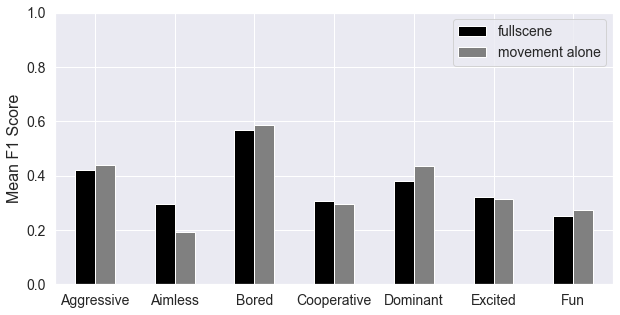

In [30]:
fs_mean = fs.iloc[[1]].T
ma_mean = ma.iloc[[1]].T

f1_mean = pd.concat([fs_mean['mean'], ma_mean['mean']], axis=1, keys=['fullscene', 'movement alone'])
f1_mean
ax = f1_mean.plot.bar(rot=0, figsize=(10,5), color=['black', 'grey']) #plot
ax.set_ylabel("Mean F1 Score", fontsize=16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(fontsize=14)
ax.set_ylim(0,1)

ax.figure.savefig('../Figs/f1labelscore.png')

In [31]:
fs_mean_chance = fschance.iloc[[1]].T
ma_mean_chance = machance.iloc[[1]].T
f1_mean_chance = pd.concat([fs_mean['mean'], fs_mean_chance['mean'], ma_mean['mean'], ma_mean_chance['mean']], axis=1, keys=['Fullscene', 'Fullscene Chance', 'Movement Alone', 'Movement Alone Chance'])

(f1_mean_chance).round(3).transpose()

,Aggressive,Aimless,Bored,Cooperative,Dominant,Excited,Fun
Fullscene,0.422,0.295,0.566,0.307,0.379,0.322,0.251
Fullscene Chance,0.202,0.166,0.111,0.181,0.198,0.177,0.100
Movement Alone,0.437,0.194,0.585,0.296,0.434,0.312,0.275
Movement Alone Chance,0.203,0.159,0.109,0.183,0.195,0.181,0.105


# Factor Analysis

Exploratory Factor Analysis examining what latent constructs underlie particiants' responses in each condition.

The Python factor_analyzer module is a port of EFA from the R' psych package.

In [32]:
import factor_analyzer

In [33]:
variable, total = factor_analyzer.calculate_kmo(fullscene_ratings_df)
print('KMO statistic Fullscene: ', total)
      
variable, total = factor_analyzer.calculate_kmo(move_ratings_df)
print('KMO statistic Movement: ', total)

KMO statistic Fullscene:  0.8761893129991386
KMO statistic Movement:  0.881698392357855


In [34]:
print('Bartlett Test Fullscene: ', factor_analyzer.calculate_bartlett_sphericity(fullscene_ratings_df))
print('Bartlett Test Movement: ', factor_analyzer.calculate_bartlett_sphericity(move_ratings_df))

Bartlett Test Fullscene:  (5219.979345955048, 0.0)
Bartlett Test Movement:  (5447.747425206299, 0.0)


In [35]:
rotation = 'promax'

nb_factors=3

efa_fullscene = factor_analyzer.FactorAnalyzer()
efa_fullscene.analyze(fullscene_ratings_df, nb_factors, rotation=rotation)
fullscene_loadings=efa_fullscene.loadings

efa_move = factor_analyzer.FactorAnalyzer()
efa_move.analyze(move_ratings_df, nb_factors, rotation=rotation)
move_loadings=efa_move.loadings

In [36]:
efa_fullscene.get_factor_variance() #variance explained by each construct for fullscene data

,Factor1,Factor2,Factor3
SS Loadings,3.961499,3.854104,3.598299
Proportion Var,0.152365,0.148235,0.138396
Cumulative Var,0.152365,0.300600,0.438996


In [37]:
efa_move.get_factor_variance() #variance explained by each construct for movement-alone data

,Factor1,Factor2,Factor3
SS Loadings,4.805225,3.677328,3.590071
Proportion Var,0.184816,0.141436,0.138080
Cumulative Var,0.184816,0.326252,0.464332


Comparing the loadings for the *fullscene* vs the *movement alone* data show that the first three factors are highly correlated. **This shows that, using factor analysis, we have uncovered latent constructs that are used by participants to describe the clips in both *fullscene* and *movement alone* conditions**.

In [38]:
# merge loadings into one dataframe, movement alone and fullscene side-by-side
loadings=pd.concat([fullscene_loadings, move_loadings], keys=["fullscene","movement alone"], axis=1)
loadings=loadings.swaplevel(0,1,1).sort_index(1)

from scipy.stats import pearsonr

print("Pearson correlation between factors 'fullscene' vs 'movement alone'")
for i in range(1, nb_factors+1):
    r, p=pearsonr(loadings["Factor%d" % i]["fullscene"].values, loadings["Factor%d" % i]["movement alone"].values)
    print("Factor %d: r=%f, p=%f" % (i,r,p)) 
    

show_heatmap(loadings[abs(loadings)>=0.3])

Pearson correlation between factors 'fullscene' vs 'movement alone'
Factor 1: r=0.937367, p=0.000000
Factor 2: r=0.835589, p=0.000000
Factor 3: r=0.809878, p=0.000001


## Social Expressivness of the EFA Embeddings

### EFA embeddings

We can use the EFA space as a 'better' space to represent our clips, where the latent, composite constructs correspond to the main axis:

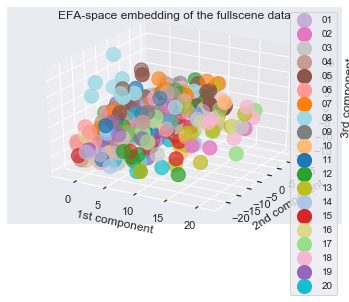

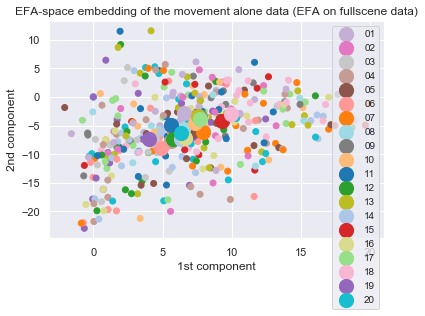

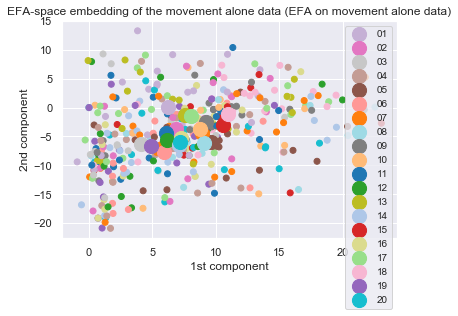

In [39]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

nb_of_factors=3
fullscene_efa = np.dot(fullscene,fullscene_loadings.values[:,:nb_of_factors])
fullscene_means_efa = np.dot(fullscene_means,fullscene_loadings.values[:,:nb_of_factors])
move_efa = np.dot(move,fullscene_loadings.values[:,:nb_of_factors])
move_means_efa = np.dot(move_means,fullscene_loadings.values[:,:nb_of_factors])

move_pure_efa = np.dot(move,move_loadings.values[:,:nb_of_factors])
move_pure_means_efa = np.dot(move_means,move_loadings.values[:,:nb_of_factors])


plot_embedding(fullscene_efa, fullscene_labels,fullscene_means_efa, fullscene_means.index, title="EFA-space embedding of the fullscene data", three_d=True)
plot_embedding(move_efa, move_labels,move_means_efa, move_means.index, title="EFA-space embedding of the movement alone data (EFA on fullscene data)", three_d=False)
plot_embedding(move_pure_efa, move_labels,move_pure_means_efa, move_means.index, title="EFA-space embedding of the movement alone data (EFA on movement alone data)", three_d=False)


Interestingly, even if the EFA factors are quite similar, the distances between the same clips in fullscene vs movement alone data are high in the EFA space:

In [40]:
distances_efa=pd.DataFrame(np.power(np.sum(np.power(move_means_efa - fullscene_means_efa, 2), axis=1), 0.5), index=move_means.index, columns=["distance_efa"])

print("Mean distance:\n%s" % distances_efa.mean(axis=0))
show_heatmap(distances_efa, cmap="summer_r")

Mean distance:
distance_efa    3.428116
dtype: float64


,distance_efa
clipId,
01,6.67003
02,1.64351
03,1.98804
04,4.6131
05,2.23726
06,4.56893
07,4.53029
08,1.74438
09,2.6114


Adding the EFA projections to the original dataframes:

In [41]:
fullscene_df["efa1"] = pd.Series(fullscene_efa[:,0], index=fullscene_df.index)
fullscene_df["efa2"] = pd.Series(fullscene_efa[:,1], index=fullscene_df.index)
fullscene_df["efa3"] = pd.Series(fullscene_efa[:,2], index=fullscene_df.index)
move_df["efa1"] = pd.Series(move_efa[:,0], index=move_df.index)
move_df["efa2"] = pd.Series(move_efa[:,1], index=move_df.index)
move_df["efa3"] = pd.Series(move_efa[:,2], index=move_df.index)

We can then re-classify the clips, comparing the performance of the original 26-dimensional ratings to the 3-dimensional EFA-space projections (*still using a 300-fold cross-validation)*:

In [42]:
nb_iterations = 300

print("Fullscene, 80%/20%...")
results_fullscene,labels_f1_fullscene = run_classification(fullscene_df, crossvalidation_iterations=nb_iterations)
print("Fullscene, 80%/20%, EFA space...")
results_fullscene_efa,labels_f1_fullscene_efa = run_classification(fullscene_df, cols=["efa1", "efa2", "efa3"], crossvalidation_iterations=nb_iterations)
print("Fullscene, chance level...")
results_fullscene_chance,labels_f1_fullscene_chance = run_classification(fullscene_df, random_labels=True, crossvalidation_iterations=nb_iterations)
print("Fullscene, 80%/20%, sanity check [input cols=['age']]...")
results_fullscene_age,labels_f1_fullscene_age = run_classification(fullscene_df, cols=["age"], crossvalidation_iterations=nb_iterations)

print("Fullscene vs skeletons...")
results_fullscene_move,labels_f1_move = run_classification(fullscene_df, testing=move_df, crossvalidation_iterations=nb_iterations)
print("Fullscene vs skeletons, EFA space...")
results_fullscene_move_efa,labels_f1_move_efa = run_classification(fullscene_df, testing=move_df, cols=["efa1", "efa2", "efa3"], crossvalidation_iterations=nb_iterations)
print("Fullscene vs skeletons, chance level...")
results_fullscene_move_chance,labels_f1_move_chance = run_classification(fullscene_df, testing=move_df, random_labels=True, crossvalidation_iterations=nb_iterations)

collated_results = pd.DataFrame({"Full-scene, EFA space": results_fullscene_efa.mean(),
                                 "Full-scene": results_fullscene.mean(),
                                 "Full-scene, chance": results_fullscene_chance.mean(),
                                 #"Full-scene-80-20-sanity-check": results_fullscene_age.mean(),
                                 "Movement-alone, EFA space": results_fullscene_move_efa.mean(),
                                 "Movement-alone": results_fullscene_move.mean(),
                                 "Movement-alone, chance": results_fullscene_move_chance.mean()})
labels_f1 = pd.concat({"Full-scene, EFA space": labels_f1_fullscene_efa,
                       "Full-scene": labels_f1_fullscene,
                       "Full-scene, chance": labels_f1_fullscene_chance,
                       #"fullscene-80-20-sanity-check": labels_f1_fullscene_age,
                       "Movement-alone, EFA": labels_f1_move_efa,
                       "Movement-alone": labels_f1_move,
                       "Movement-alone, chance": labels_f1_move_chance}, axis=1)

Fullscene, 80%/20%...
Shape of training data: (316, 30)
Shape of testing data: (80, 30)
Fullscene, 80%/20%, EFA space...
Shape of training data: (316, 3)
Shape of testing data: (80, 3)
Fullscene, chance level...
Shape of training data: (316, 30)
Shape of testing data: (80, 30)
Fullscene, 80%/20%, sanity check [input cols=['age']]...
Shape of training data: (316, 1)
Shape of testing data: (80, 1)
Fullscene vs skeletons...
Shape of training data: (396, 30)
Shape of testing data: (400, 30)
Fullscene vs skeletons, EFA space...
Shape of training data: (396, 3)
Shape of testing data: (400, 3)
Fullscene vs skeletons, chance level...
Shape of training data: (396, 30)
Shape of testing data: (400, 30)


In [43]:
collated_results.round(3)

,"Full-scene, EFA space",Full-scene,"Full-scene, chance","Movement-alone, EFA space",Movement-alone,"Movement-alone, chance"
Accuracy,0.112,0.151,0.040,0.117,0.157,0.039
Precision,0.383,0.445,0.285,0.351,0.416,0.280
Recall,0.263,0.320,0.147,0.270,0.327,0.141
F1-measure,0.300,0.361,0.183,0.303,0.363,0.178


In [44]:
fullscene = labels_f1.loc[:, 'Full-scene']
fullsceneEFA = labels_f1.loc[:, 'Full-scene, EFA space']
fullsceneChance = labels_f1.loc[:, 'Full-scene, chance']
movement = labels_f1.loc[:, 'Movement-alone']
movementEFA = labels_f1.loc[:, 'Movement-alone, EFA']
movementChance = labels_f1.loc[:, 'Movement-alone, chance']

collated_labels = pd.DataFrame([fullsceneEFA.mean(axis=0)])
collated_labels = collated_labels.append([fullscene.mean(axis=0)],ignore_index=True)
collated_labels = collated_labels.append([fullsceneChance.mean(axis=0)],ignore_index=True)
collated_labels = collated_labels.append([movementEFA.mean(axis=0)],ignore_index=True)
collated_labels = collated_labels.append([movement.mean(axis=0)],ignore_index=True)
collated_labels = collated_labels.append([movementChance.mean(axis=0)],ignore_index=True)

collated_labels.rename(index={0:'Fullscene, EFA',1:'Fullscene',2:'Chance',
                              3:'Movement alone, EFA',4:'Movement alone',5:'Chance'}, inplace=True)
collated_labels

,Aggressive,Aimless,Bored,Cooperative,Dominant,Excited,Fun
"Fullscene, EFA",0.379803,0.162670,0.538918,0.294148,0.297218,0.260524,0.203886
Fullscene,0.421510,0.294529,0.566090,0.307417,0.378689,0.322202,0.250625
Chance,0.187135,0.177001,0.114410,0.189390,0.209056,0.177376,0.118239
"Movement alone, EFA",0.364964,0.240000,0.492308,0.246305,0.337079,0.273810,0.122449
Movement alone,0.437276,0.193548,0.584615,0.295918,0.433824,0.312139,0.274510
Chance,0.198971,0.157474,0.101664,0.191208,0.194350,0.175476,0.108665
